<a href="https://colab.research.google.com/github/fatusilva/test/blob/master/TFM_CSAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabajo Fin de Máster (TFM)
## Predicción de la satisfacción del cliente (CSAT) en un Contact Center
---
Este notebook sigue la misma estructura aplicada en los trabajos prácticos del máster, adaptado para cargar el archivo desde Google Drive mediante enlace público.

In [ ]:
!pip -q install xgboost imbalanced-learn


In [2]:
import numpy as np
import pandas as pd
import re
from datetime import datetime

# Modelado / Métricas
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Opcional (plots)
import matplotlib.pyplot as plt
import seaborn as sns

# XGBoost
from xgboost import XGBClassifier

pd.set_option('display.max_colwidth', 120)
pd.set_option('display.max_columns', 200)


In [3]:
from google.colab import files
uploaded = files.upload()  # subí tu .xlsx
FILE_PATH = list(uploaded.keys())[0]
SHEET_NAME = None  # o el nombre de la hoja si querés especificar

 #from google.colab import drive
 #drive.mount('/content/drive')
 #FILE_PATH = '/content/drive/MyDrive/BaseEncuestasClientes.xlsx'
# SHEET_NAME = None


Saving BaseEncuestasClientes.xlsx to BaseEncuestasClientes.xlsx


In [4]:
import pandas as pd

# Ver qué hojas tiene el archivo
xl = pd.ExcelFile(FILE_PATH)
print("Hojas encontradas:", xl.sheet_names)

# Usa la primera hoja (o cambia el índice 0 por 1, 2, etc. si querés otra)
df = pd.read_excel(FILE_PATH, sheet_name=0, header=1)

# Normalizar nombres
df.columns = [str(c).strip() for c in df.columns]

print("Shape inicial:", df.shape)
print("Primeras columnas:", df.columns[:10].tolist())
df.head()

Hojas encontradas: ['Sheet0']
Shape inicial: (38005, 104)
Primeras columnas: ['Fecha de inicio', 'Fecha de finalización', 'Progreso', 'Duración (en segundos)', 'Finalizado', 'Fecha registrada', 'ID de respuesta', 'Apellido del destinatario', 'Nombre del destinatario', 'Referencia a datos externos']


,Fecha de inicio,Fecha de finalización,Progreso,Duración (en segundos),Finalizado,Fecha registrada,ID de respuesta,Apellido del destinatario,Nombre del destinatario,Referencia a datos externos,Latitud de la ubicación,Longitud de la ubicación,Canal de la distribución,Idioma del usuario,¿Resolvimos tu consulta?,¿Cómo calificas tu experiencia en la sucursal?,¿Cómo calificas el tiempo de espera en la sucursal?,¿Cómo calificas la organización de la sucursal para atender tu consulta?,¿Cómo calificas la comodidad de las instalaciones en la sucursal?,¿Cómo calificás la atención recibida por nuestro ejecutivo/a en la sucursal?,¿Cómo calificás la atención recibida por nuestro equipo de experiencia?,¿Algo más que nos quieras compartir?,genero,rango_etario,cluster,ciudad,cuenta_creada,tarjeta_fisica_credito,ultimo_movimiento_tc,tarjeta_fisica_debito,oferta_preaprobada_activa_prestamo,prestamo_activo,ultimo_movimiento_qr,ultima_transferencia,contrato_unico_firmado,ultimo_pago_servicios,tarjeta_duocard,oferta_preaprobada_activa_tc,derivacion_caso,grupo_producto,motivo_contacto,motivo_reclamo,resolucion_favor_cliente,ticket_id,tiempo_resolucion,ya_es_cliente,agente_asignado_vinanzas,agente_asignado_operaciones,persona_asignada,sent_date,canal_de_transacción,departamento,cliente_origen,bandeja,canal_ticket,Formulario CSAT,Etiquetas,agente_asignado,Estado,CaseNumber_sf,Id_sf,Origin_sf,Reason_sf,Executive_sf,sourceObject_sf,sucursal_sf,Producto_sf,Prioridad_sf,Descripcion_sf,Type_sf,Timeescalated_sf,Subproduct_sf,ROTDerivation_sf,ejecutivo_email_sf,fecha_creacion_caso_sf,fecha_cierre_caso_sf,Recontacto_sf,segmento,SurveyID,recordType,CSAT Atención Digital N,CSAT Atención Sucursal N,CSAT Comodidad Suc N,CSAT General,CSAT Organización Suc N,CSAT Sucursal N,CSAT Tiempo Suc N,Q3 - Actionability,Q3 - Effort,Q3 - Effort Numeric,Q3 - Emotion Intensity,Q3 - Emotion,Q3 - Parent Topics,Q3 - Sentiment Polarity,Q3 - Sentiment Score,Q3 - Sentiment,Q3 - Topic Sentiment Label,Q3 - Topic Sentiment Score,Q3 - Topics,Producto_type_sf,Regiones,Tipo de Atención,Regiones_sf,Q3 - Topic Hierarchy Level 1
0,2024-12-31 22:39:41,2024-12-31 22:40:06,100,25,True,2024-12-31 22:40:07.404,R_3q5vTMtZYmzSu3v,ALSINA,MARIA,NaN,-23.3333,-58.0000,email,ES,Sí,NaN,NaN,NaN,NaN,NaN,5 Muy Buena,Gracias por la ayuda brindada! Feliz año nuevo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,deriva_a_sin_derivación,NaN,NaN,NaN,NaN,3685286.0,NaN,ya_es_cliente,NaN,NaN,Enzo Florentin,NaN,NaN,NaN,NaN,redes_sociales_c,NaN,formulario_digital,buenas ci_actualizado consulta cuenta deriva_a_sin_derivación desvio_automatico email_cst formulario_digital motivo_...,NaN,Cerrado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SV_e96vbeWvrEmvs10,Satisfaccion_y_resolucion_de_caso,5.0,NaN,NaN,5.0,NaN,NaN,NaN,other,Easy,1.0,Medium,Thankfulness,NaN,0.0,1.0,Positive,NaN,NaN,Unknown,NaN,Sin categoría,Digital y Telefónico,NaN,NaN
1,2024-12-31 23:00:38,2024-12-31 23:00:48,100,9,True,2024-12-31 23:00:48.963,R_3EuIo9OuYEyUwhk,LEGUIZAMON,MARIO,NaN,-25.2869,-57.6511,email,ES,Sí,NaN,NaN,NaN,NaN,NaN,5 Muy Buena,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,redes_sociales_,tarjetas__,NaN,NaN,NaN,3684772.0,NaN,ya_es_cliente,NaN,NaN,Gerson Rodas,NaN,canal_tx_no_aplica,NaN,NaN,redes_sociales_c,NaN,formulario_digital,_no_ canal_tx_no_aplica casuisticas_loyalty_beneficios_reintegro_historial_de_reintegro chatinapp ci_actualizado con...,NaN,Cerrado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SV_e96vbeWvrEmvs10,Satisfaccion_y_resolucion_de_caso,5.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sin categoría,Digital y Telefónico,NaN,NaN
2,2024-12-31 23:06:09,2024-12-31 23:06:47,100,37,True,2024-12-31 23:06:47.916,R_3kyS43P8QCgHTS1,ESCOBAR,ALMA,NaN,-25.2869,-57.6511,email,ES,Sí,NaN,NaN,NaN,NaN,NaN,5 Muy Buena,Feliz Año 2025!,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,segunda_linea,

In [6]:
# Detectar y convertir columnas de fechas si existen
posibles_fecha_encuesta = ['Fecha registrada', 'Fecha Registrada']
fecha_encuesta_col = next((c for c in posibles_fecha_encuesta if c in df.columns), None)

if fecha_encuesta_col:
    df[fecha_encuesta_col] = pd.to_datetime(df[fecha_encuesta_col], errors='coerce')

# cuenta_creada (alta del cliente)
if 'cuenta_creada' in df.columns:
    df['cuenta_creada'] = pd.to_datetime(df['cuenta_creada'], errors='coerce')

# Antigüedad del cliente en meses (aprox; días/30.44)
if fecha_encuesta_col and 'cuenta_creada' in df.columns:
    diff_days = (df[fecha_encuesta_col] - df['cuenta_creada']).dt.days
    df['antiguedad_cliente_meses'] = (diff_days / 30.44).clip(lower=0)
else:
    df['antiguedad_cliente_meses'] = np.nan

# Derivados temporales (si hay fecha de encuesta)
if fecha_encuesta_col:
    df['mes_encuesta'] = df[fecha_encuesta_col].dt.month
    df['dia_semana_encuesta'] = df[fecha_encuesta_col].dt.weekday
    df['hora_encuesta'] = df[fecha_encuesta_col].dt.hour

print("Shape inicial:", df.shape)
print("Primeras columnas:", df.columns[:10].tolist())
df.head()

Shape inicial: (38005, 108)
Primeras columnas: ['Fecha de inicio', 'Fecha de finalización', 'Progreso', 'Duración (en segundos)', 'Finalizado', 'Fecha registrada', 'ID de respuesta', 'Apellido del destinatario', 'Nombre del destinatario', 'Referencia a datos externos']


,Fecha de inicio,Fecha de finalización,Progreso,Duración (en segundos),Finalizado,Fecha registrada,ID de respuesta,Apellido del destinatario,Nombre del destinatario,Referencia a datos externos,Latitud de la ubicación,Longitud de la ubicación,Canal de la distribución,Idioma del usuario,¿Resolvimos tu consulta?,¿Cómo calificas tu experiencia en la sucursal?,¿Cómo calificas el tiempo de espera en la sucursal?,¿Cómo calificas la organización de la sucursal para atender tu consulta?,¿Cómo calificas la comodidad de las instalaciones en la sucursal?,¿Cómo calificás la atención recibida por nuestro ejecutivo/a en la sucursal?,¿Cómo calificás la atención recibida por nuestro equipo de experiencia?,¿Algo más que nos quieras compartir?,genero,rango_etario,cluster,ciudad,cuenta_creada,tarjeta_fisica_credito,ultimo_movimiento_tc,tarjeta_fisica_debito,oferta_preaprobada_activa_prestamo,prestamo_activo,ultimo_movimiento_qr,ultima_transferencia,contrato_unico_firmado,ultimo_pago_servicios,tarjeta_duocard,oferta_preaprobada_activa_tc,derivacion_caso,grupo_producto,motivo_contacto,motivo_reclamo,resolucion_favor_cliente,ticket_id,tiempo_resolucion,ya_es_cliente,agente_asignado_vinanzas,agente_asignado_operaciones,persona_asignada,sent_date,canal_de_transacción,departamento,cliente_origen,bandeja,canal_ticket,Formulario CSAT,Etiquetas,agente_asignado,Estado,CaseNumber_sf,Id_sf,Origin_sf,Reason_sf,Executive_sf,sourceObject_sf,sucursal_sf,Producto_sf,Prioridad_sf,Descripcion_sf,Type_sf,Timeescalated_sf,Subproduct_sf,ROTDerivation_sf,ejecutivo_email_sf,fecha_creacion_caso_sf,fecha_cierre_caso_sf,Recontacto_sf,segmento,SurveyID,recordType,CSAT Atención Digital N,CSAT Atención Sucursal N,CSAT Comodidad Suc N,CSAT General,CSAT Organización Suc N,CSAT Sucursal N,CSAT Tiempo Suc N,Q3 - Actionability,Q3 - Effort,Q3 - Effort Numeric,Q3 - Emotion Intensity,Q3 - Emotion,Q3 - Parent Topics,Q3 - Sentiment Polarity,Q3 - Sentiment Score,Q3 - Sentiment,Q3 - Topic Sentiment Label,Q3 - Topic Sentiment Score,Q3 - Topics,Producto_type_sf,Regiones,Tipo de Atención,Regiones_sf,Q3 - Topic Hierarchy Level 1,antiguedad_cliente_meses,mes_encuesta,dia_semana_encuesta,hora_encuesta
0,2024-12-31 22:39:41,2024-12-31 22:40:06,100,25,True,2024-12-31 22:40:07.404,R_3q5vTMtZYmzSu3v,ALSINA,MARIA,NaN,-23.3333,-58.0000,email,ES,Sí,NaN,NaN,NaN,NaN,NaN,5 Muy Buena,Gracias por la ayuda brindada! Feliz año nuevo,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,deriva_a_sin_derivación,NaN,NaN,NaN,NaN,3685286.0,NaN,ya_es_cliente,NaN,NaN,Enzo Florentin,NaN,NaN,NaN,NaN,redes_sociales_c,NaN,formulario_digital,buenas ci_actualizado consulta cuenta deriva_a_sin_derivación desvio_automatico email_cst formulario_digital motivo_...,NaN,Cerrado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SV_e96vbeWvrEmvs10,Satisfaccion_y_resolucion_de_caso,5.0,NaN,NaN,5.0,NaN,NaN,NaN,other,Easy,1.0,Medium,Thankfulness,NaN,0.0,1.0,Positive,NaN,NaN,Unknown,NaN,Sin categoría,Digital y Telefónico,NaN,NaN,NaN,12,1,22
1,2024-12-31 23:00:38,2024-12-31 23:00:48,100,9,True,2024-12-31 23:00:48.963,R_3EuIo9OuYEyUwhk,LEGUIZAMON,MARIO,NaN,-25.2869,-57.6511,email,ES,Sí,NaN,NaN,NaN,NaN,NaN,5 Muy Buena,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,redes_sociales_,tarjetas__,NaN,NaN,NaN,3684772.0,NaN,ya_es_cliente,NaN,NaN,Gerson Rodas,NaN,canal_tx_no_aplica,NaN,NaN,redes_sociales_c,NaN,formulario_digital,_no_ canal_tx_no_aplica casuisticas_loyalty_beneficios_reintegro_historial_de_reintegro chatinapp ci_actualizado con...,NaN,Cerrado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SV_e96vbeWvrEmvs10,Satisfaccion_y_resolucion_de_caso,5.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sin categoría,Digital y Telefónico,NaN,NaN,NaN,12,1,23
2,2024-12-31 23:06:09,2024-12-31 23:06:47,100,37,True,2024-12-31 23:06:47.916,R_3kyS43P8QCgHTS1,ESCOBAR,ALMA,NaN,-25.2869,-57.6511,email,ES,Sí,NaN,NaN,NaN,NaN,NaN,5 Muy Buen

In [7]:
# CSAT General -> binaria: 1 si CSAT >= 4, 0 en caso contrario
assert 'CSAT General' in df.columns, "No se encontró 'CSAT General' en el dataset."
df['CSAT_bin'] = (df['CSAT General'] >= 4).astype(int)

# ⚠️ Eliminar variables de fuga relacionadas a resolución (si están)
fuga_patterns = ['resoluc', 'Respuesta Resolucion','¿Resolvimos tu consulta?']
cols_fuga = [c for c in df.columns if any(pat.lower() in c.lower() for pat in fuga_patterns)]
df = df.drop(columns=cols_fuga, errors='ignore')

print("Columnas de fuga eliminadas:", cols_fuga)
print("Distribución CSAT_bin:\n", df['CSAT_bin'].value_counts(normalize=True).round(4)*100)


Columnas de fuga eliminadas: ['¿Resolvimos tu consulta?', 'resolucion_favor_cliente', 'tiempo_resolucion']
Distribución CSAT_bin:
 CSAT_bin
1    72.76
0    27.24
Name: proportion, dtype: float64


In [8]:
# Elegir columna origen (puede llamarse 'motivo_contacto' o similar):
posibles_motivo = ['motivo_contacto']
motivo_col = next((c for c in posibles_motivo if c in df.columns), None)

def agrupar_motivos_texto(valor):
    if pd.isna(valor):
        return 'Otro'
    v = str(valor).lower()
    # Tarjeta
    if any(k in v for k in ['tarjeta', 'plástico', 'pin', 'visa', 'mastercard', 'extravio', 'bloqueo']):
        return 'Tarjeta'
    # Préstamos / créditos
    if any(k in v for k in ['préstam', 'prestam', 'cuota', 'sobregiro', 'credito', 'crédito']):
        return 'Préstamos'
    # Transferencias / pagos / QR / billeteras / ATM
    if any(k in v for k in ['transferen', 'pago', 'qr', 'ted', 'atm', 'alias', 'debito', 'débito', 'swift', 'cnb']):
        return 'Transferencias/ Pagos'
    # Cuenta / App / Acceso / Onboarding
    if any(k in v for k in ['cuenta', 'onboarding', 'contraseña', 'password', 'app', 'login', 'web', 'canal']):
        return 'Cuenta/App'
    # Ofertas / Comercial / Promos
    if any(k in v for k in ['oferta', 'promoc', 'comercial', 'venta', 'promo']):
        return 'Ofertas/Comercial'
    # Fraude / seguridad
    if any(k in v for k in ['fraude', 'estafa', 'seguridad', 'vulneración', 'robo']):
        return 'Fraude/Seguridad'
    # Inversiones / CDA / fondos / casa de bolsa
    if any(k in v for k in ['cda', 'fondo', 'invers', 'bolsa']):
        return 'Inversiones'
    # Servicios / facturas
    if any(k in v for k in ['servicio', 'factura', 'facturador']):
        return 'Servicios'
    # Generales / Operativos
    if any(k in v for k in ['consulta', 'requisito', 'condicion', 'soporte', 'ayuda', 'informacion', 'información']):
        return 'Operativo/Soporte'
    return 'Otro'

if motivo_col:
    # Si ya está codificado con números, no sirve. Intentamos recuperar texto. Si no, seguimos.
    if df[motivo_col].dtype == object:
        df['motivo_contacto_categoria'] = df[motivo_col].apply(agrupar_motivos_texto)
    else:
        # Si ya está como números por LabelEncoder, usá la columna textual equivalente si la tenés.
        # Si no tenés el texto original, vas a agrupar a 'Otro' (mejor rehacer antes de codificar).
        df['motivo_contacto_categoria'] = 'Otro'
else:
    df['motivo_contacto_categoria'] = 'Otro'

df['motivo_contacto_categoria'] = df['motivo_contacto_categoria'].fillna('Otro')

print("Top categorías motivo_contacto_categoria:")
print(df['motivo_contacto_categoria'].value_counts().head(10))


Top categorías motivo_contacto_categoria:
motivo_contacto_categoria
Otro                     16542
Tarjeta                   6480
Ofertas/Comercial         3730
Transferencias/ Pagos     3703
Cuenta/App                3084
Préstamos                 2248
Operativo/Soporte         1409
Servicios                  622
Fraude/Seguridad           111
Inversiones                 76
Name: count, dtype: int64


In [11]:
for name in ['X','y','X_train','X_test','y_train','y_test','X_train_scaled','X_test_scaled']:
    if name in globals():
        del globals()[name]

In [12]:
# 1) Lista blanca de columnas (ajustá nombres según existan en tu df)
whitelist = [
    # Cliente / perfil
    'antiguedad_cliente_meses','rango_etario','segmento','cluster','genero','ciudad','Regiones','Regiones_sf','ya_es_cliente',
    # Canal / flujo
    'canal_ticket','Canal','canal_de_transacción','Tipo de Atención','tipo_registro_caso','bandeja','Area','departamento',
    # Producto / motivo
    'Producto_sf','Subproduct_sf','grupo_producto','motivo_contacto_categoria',
    # Tiempo / operación
    'Duración (en segundos)','mes_encuesta','dia_semana_encuesta','hora_encuesta'
]

# 2) Construir df_modelo solo con whitelist + target
cols_existentes = [c for c in whitelist if c in df.columns]
df_modelo = df[cols_existentes + ['CSAT_bin']].copy()

print("✅ Columnas usadas:", df_modelo.columns.tolist())

# 3) (doble seguro) No permitir CSAT* ni Resoluc* en features
ban_patterns = ['csat', 'satisf', 'resoluc']
cols_ban = [c for c in df_modelo.columns if any(p in c.lower() for p in ban_patterns) and c != 'CSAT_bin']
if cols_ban:
    df_modelo = df_modelo.drop(columns=cols_ban)
    print("🚫 Quitadas por seguridad:", cols_ban)

# 4) Separar X/y
X = df_modelo.drop(columns=['CSAT_bin']).copy()
y = df_modelo['CSAT_bin'].astype(int)

# 5) Codificar solo las categóricas que queden en X
from sklearn.preprocessing import LabelEncoder
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le
print("🔤 Categóricas codificadas:", cat_cols)

# 6) Imputación (por si queda algún NaN)
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='mean')
X = pd.DataFrame(imp.fit_transform(X), columns=X.columns)

# 7) Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("📊 y_train %:\n", (y_train.value_counts(normalize=True)*100).round(2))


✅ Columnas usadas: ['antiguedad_cliente_meses', 'rango_etario', 'segmento', 'cluster', 'genero', 'ciudad', 'Regiones', 'Regiones_sf', 'ya_es_cliente', 'canal_ticket', 'canal_de_transacción', 'Tipo de Atención', 'bandeja', 'departamento', 'Producto_sf', 'Subproduct_sf', 'grupo_producto', 'motivo_contacto_categoria', 'Duración (en segundos)', 'mes_encuesta', 'dia_semana_encuesta', 'hora_encuesta', 'CSAT_bin']
🔤 Categóricas codificadas: ['rango_etario', 'segmento', 'genero', 'ciudad', 'Regiones', 'Regiones_sf', 'ya_es_cliente', 'canal_ticket', 'canal_de_transacción', 'Tipo de Atención', 'bandeja', 'departamento', 'Producto_sf', 'Subproduct_sf', 'grupo_producto', 'motivo_contacto_categoria']
📊 y_train %:
 CSAT_bin
1    72.76
0    27.24
Name: proportion, dtype: float64


📌 Clasification Report — Regresión Logística (sin resolución):
              precision    recall  f1-score   support

           0       0.56      0.11      0.18      2071
           1       0.74      0.97      0.84      5530

    accuracy                           0.73      7601
   macro avg       0.65      0.54      0.51      7601
weighted avg       0.69      0.73      0.66      7601

📈 ROC-AUC: 0.6802647950732714


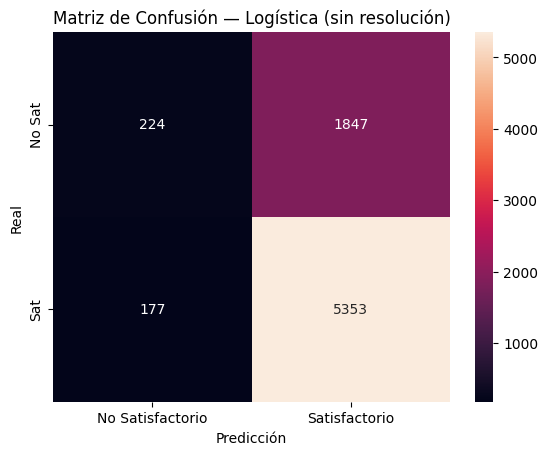

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

modelo_log = LogisticRegression(max_iter=8000)
modelo_log.fit(X_train_scaled, y_train)

y_pred_log = modelo_log.predict(X_test_scaled)
y_proba_log = modelo_log.predict_proba(X_test_scaled)[:, 1]

print("📌 Clasification Report — Regresión Logística (sin resolución):")
print(classification_report(y_test, y_pred_log))
print("📈 ROC-AUC:", roc_auc_score(y_test, y_proba_log))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_log)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['No Satisfactorio', 'Satisfactorio'], yticklabels=['No Sat', 'Sat'])
plt.title("Matriz de Confusión — Logística (sin resolución)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


📌 Clasification Report — Random Forest (sin resolución):
              precision    recall  f1-score   support

           0       0.62      0.29      0.40      2071
           1       0.78      0.93      0.85      5530

    accuracy                           0.76      7601
   macro avg       0.70      0.61      0.62      7601
weighted avg       0.74      0.76      0.73      7601

📈 ROC-AUC: 0.7462171134490505


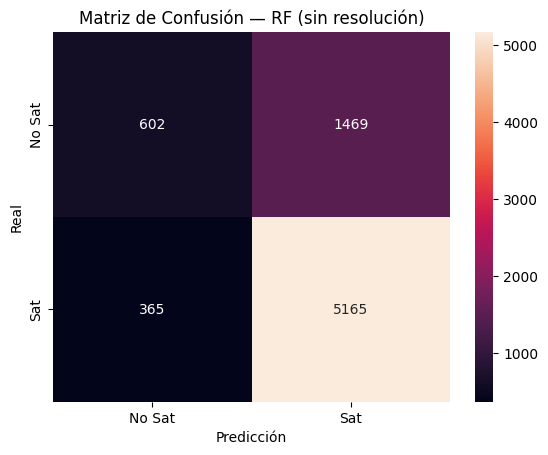

In [14]:
modelo_rf = RandomForestClassifier(n_estimators=200, random_state=42)
modelo_rf.fit(X_train, y_train)

y_pred_rf = modelo_rf.predict(X_test)
y_proba_rf = modelo_rf.predict_proba(X_test)[:, 1]

print("📌 Clasification Report — Random Forest (sin resolución):")
print(classification_report(y_test, y_pred_rf))
print("📈 ROC-AUC:", roc_auc_score(y_test, y_proba_rf))

cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['No Sat', 'Sat'], yticklabels=['No Sat', 'Sat'])
plt.title("Matriz de Confusión — RF (sin resolución)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


📌 Clasification Report — XGBoost (sin resolución):
              precision    recall  f1-score   support

           0       0.62      0.30      0.41      2071
           1       0.78      0.93      0.85      5530

    accuracy                           0.76      7601
   macro avg       0.70      0.62      0.63      7601
weighted avg       0.74      0.76      0.73      7601

📈 ROC-AUC: 0.7533013377713242


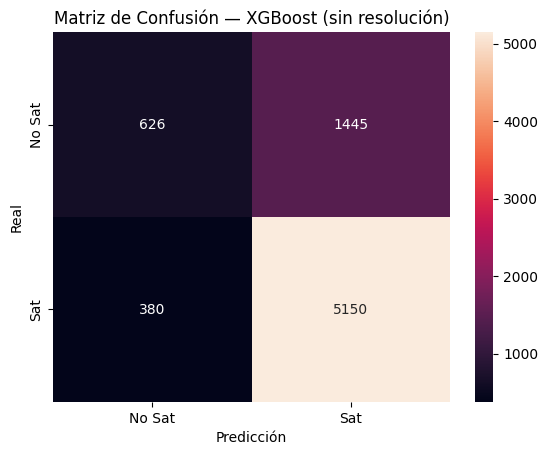

In [15]:
modelo_xgb = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)
modelo_xgb.fit(X_train, y_train)

y_pred_xgb = modelo_xgb.predict(X_test)
y_proba_xgb = modelo_xgb.predict_proba(X_test)[:, 1]

print("📌 Clasification Report — XGBoost (sin resolución):")
print(classification_report(y_test, y_pred_xgb))
print("📈 ROC-AUC:", roc_auc_score(y_test, y_proba_xgb))

cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['No Sat', 'Sat'], yticklabels=['No Sat', 'Sat'])
plt.title("Matriz de Confusión — XGBoost (sin resolución)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()


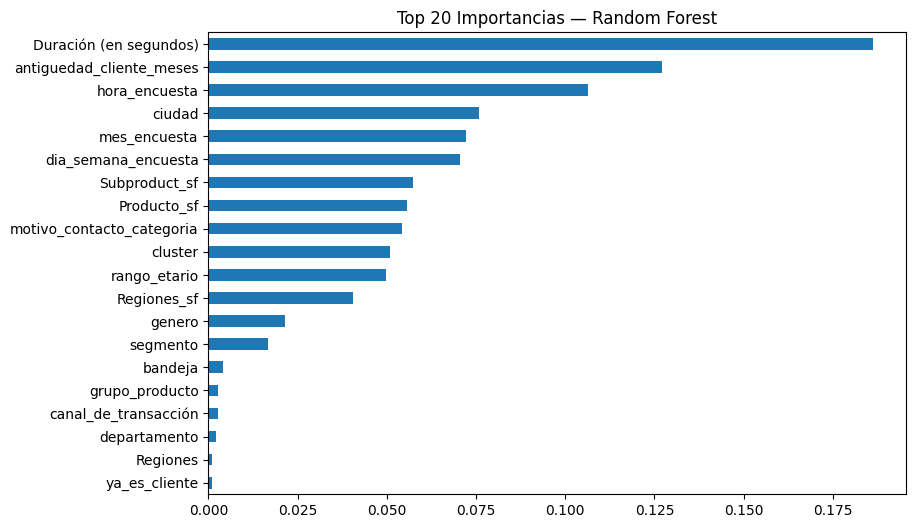

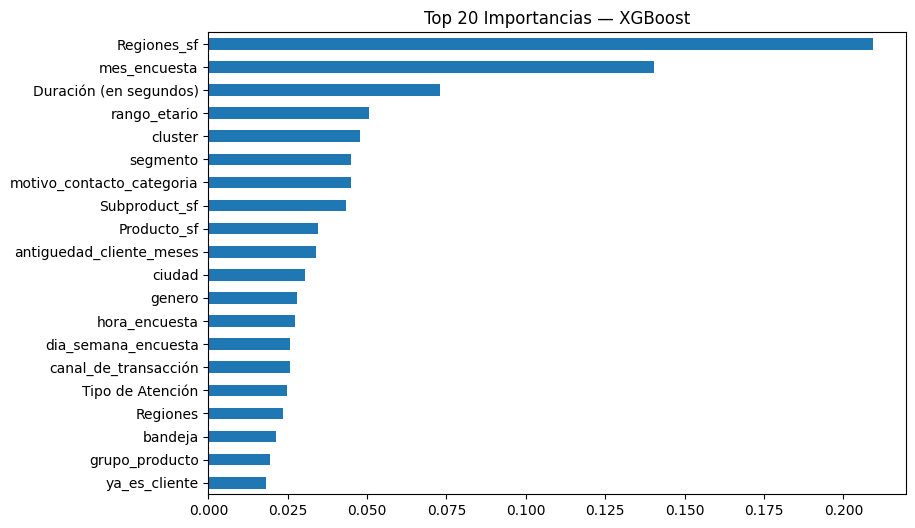

In [16]:
# Random Forest
imp_rf = pd.Series(modelo_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(20)
plt.figure(figsize=(9,6))
imp_rf[::-1].plot(kind='barh')
plt.title("Top 20 Importancias — Random Forest")
plt.show()

# XGBoost
imp_xgb = pd.Series(modelo_xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(20)
plt.figure(figsize=(9,6))
imp_xgb[::-1].plot(kind='barh')
plt.title("Top 20 Importancias — XGBoost")
plt.show()


✅ *Este notebook aplica el flujo aprendido en los trabajos prácticos del máster, y permite iniciar el análisis directamente desde un archivo Excel público de Google Drive.*